In [19]:
import matplotlib.pyplot as plt
import numpy as np
from GRAPE.multiqubitgates import Pulse, Evolution, Inversion, CXCascade
from GRAPE.circuit import Circuit, OneQubitEntanglementAlternation
from GRAPE.optimizer import GradientOptimization
from GRAPE.optimizer_old import GradientDescent

def norm(matrix1, matrix2):
    return ((matrix1 - matrix2) @ (matrix1 - matrix2).conjugate().T).trace()

cx = np.asarray([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]], dtype=complex)

toffoli = np.asarray([[1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1],
                      [0, 0, 0, 0, 0, 0, 1, 0]], dtype=complex)

hamiltonian = np.zeros((3, 3))
hamiltonian[0][1] = 0.1385
hamiltonian[1][2] = 0.01304
hamiltonian[0][2] = 0.00148

target = toffoli
size = int(np.log2(target.shape[0]))
circuit = OneQubitEntanglementAlternation(size, Evolution, 4, one_qubit_gate_type="nmr")

opt = GradientOptimization(target, circuit)
opt.randomize_params()
opt.set_hamiltonian(hamiltonian[:size][:size])
opt.learning_rate = 0.01

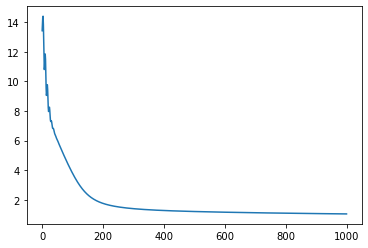

In [20]:
loss = opt.descend(steps=1000, track_distance=True)
plt.plot(loss)

In [21]:
opt.time




272.1637975509872